# Goal: Predict stroke using XGBoost.
# Dataset:  https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
# Steps: 
## Data Pre-processing
### Convert categorical data to numerical data.
### Fix missing values with mean values.
### Oversampling minority class data (strokes). 
## Check any correlation between the data attributes.
## Data normalization via the onehot and min and max scaling transformations.
## Train the model (split the dataset into 80/20 for training and testing and further split the 80 into 80/20 for training and validation)
## Use the model to predict.
# Result:  
## Accuracy: 0.967095115681234
## Precision: 0.9391056137012369
## Recall: 1.0
## F1 Score: 0.9685966633954857

In [19]:
import pandas as pda
import numpy as np
import math

from sklearn.utils import resample

#Loading data from csv
heart_df = pda.read_csv('healthcare-dataset-stroke-data.csv')

#Converting categorical data into intial numerical data to compute correlations.  Later onehot transformation will apply
heart_df['gender'].replace(['Male', 'Female', 'Other'],[0, 1, 2], inplace=True)
heart_df['ever_married'].replace(['No', 'Yes'],[0, 1], inplace=True)
heart_df['work_type'].replace(['children', 'Govt_job', 'Never_worked', 'Private', 'Self-employed'], [0, 1, 2, 3, 4], inplace=True)
heart_df['Residence_type'].replace(['Urban', 'Rural'],[0, 1], inplace=True)
bmi_avg = heart_df['bmi'].mean()
heart_df['bmi'].fillna(bmi_avg, inplace = True)
heart_df['smoking_status'].replace(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],[0, 1, 2, 3], inplace=True)
#remove id column
headers = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
hs_df = heart_df[headers]

hs_df_strokes = hs_df[hs_df['stroke'] == 1]
hs_df_nostrokes = hs_df[hs_df['stroke'] == 0]

hs_strokes_oversampling = resample(hs_df_strokes, n_samples = hs_df_nostrokes.shape[0])
hs_df = pda.concat([hs_strokes_oversampling, hs_df_nostrokes], axis=0)
hs_df = hs_df.sample(frac=1).reset_index(drop=True)

hs_df


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,44.0,0,0,1,1,0,97.16,33.1,3,0
1,1,78.0,1,0,0,3,0,130.54,20.1,1,1
2,0,5.0,0,0,0,0,1,67.28,17.7,3,0
3,1,77.0,0,0,1,3,0,105.22,31.0,1,1
4,1,79.0,0,0,1,3,1,93.05,24.2,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9717,1,63.0,0,0,1,1,1,106.58,23.9,3,1
9718,1,66.0,0,0,1,3,1,87.84,52.8,3,0
9719,1,68.0,0,0,1,3,1,233.59,43.9,1,0
9720,1,79.0,0,0,1,3,0,110.85,24.1,0,1


<Axes: >

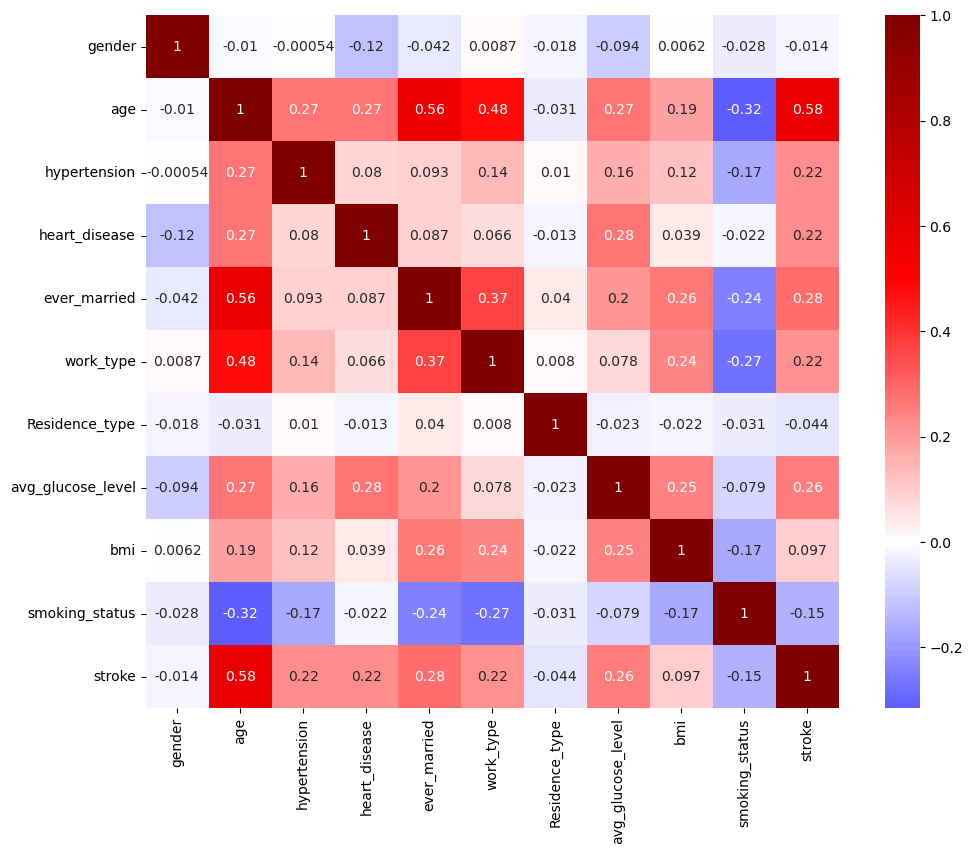

In [20]:
import matplotlib.pyplot as plot
import seaborn as sb

plot.figure(figsize = (12, 9))
corrMatrix = hs_df.corr()
sb.heatmap(corrMatrix, square = True, annot = True, center = 0, cmap = 'seismic')

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

#attribute normalization functions
def attribute_normalization():
    scaler = MinMaxScaler()
    ohe = OneHotEncoder(sparse_output = False)

    column_transform = make_column_transformer((ohe,['gender']),
                                               (scaler, ['age']), 
                                               (ohe,['hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type']),
                                               (scaler, ['avg_glucose_level', 'bmi']),
                                               (ohe,['smoking_status'])
                                              )

    return column_transform


In [37]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

X = hs_df.iloc[:,0:10]
y = hs_df.iloc[:,10]

# Data normalization
transformer = attribute_normalization()
XX = transformer.fit_transform(X)

# Split data into train, test and validation
X_trainAll, X_test, y_trainAll, y_test = train_test_split(XX, y, test_size = 0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainAll, y_trainAll, test_size = 0.2)

feature_names = transformer.get_feature_names_out()
X_train_df = pda.DataFrame(X_train, columns = feature_names)
X_valid_df = pda.DataFrame(X_valid, columns = feature_names)
X_test_df  = pda.DataFrame(X_test, columns = feature_names)
y_train_df = pda.DataFrame(y_train, columns = ['stroke'])
y_valid_df = pda.DataFrame(y_valid, columns = ['stroke'])
y_test_df  = pda.DataFrame(y_test, columns = ['stroke'])

model = XGBClassifier(tree_method="hist")
model.fit(X_train_df, y_train_df, eval_set=[(X_valid_df, y_valid_df)], verbose=False)
y_test_xgb = model.predict(X_test_df)
y_test_xgb = (y_test_xgb > 0.5)

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test_df, y_test_xgb)
precision = precision_score(y_test_df, y_test_xgb)
recall = recall_score(y_test_df, y_test_xgb)
f1 = f1_score(y_test_df, y_test_xgb)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.967095115681234
Precision: 0.9391056137012369
Recall: 1.0
F1 Score: 0.9685966633954857
